# Jaké rysy dělají ze skladby hit?

## Analýza charakteristických atributů hudebních skladeb ze Spotify

Předmětem analýzy jsou charakteristické atributy skladeb ze Spotify, jako je jejich tempo, tónina, energičnost, délka apod. (celkem 19 atributů). Cílová proměnná je údaj, zda se skladba v daném období stala populárním mainstreamovým hitem či nikoli (hit/flop) a tuto vlastnost se také budeme snažit predikovat. Jde o ověření domněnky, že všeobecně přijímané populární skladby mají jisté společné měřitelné vlastnosti a jejich líbivost lze algoritmicky dokázat, případně i predikovat a strojově vytvářet.

## Popis dat a jejich struktury 

Pro analýzu je k dispozici široká a volně stažitelná databáze záznamů o všech skladbách dostupných na Spotify přes Spotify API. Pro tuto semestrální práci využijeme již předzpracovaný dataset z Kaggle https://www.kaggle.com/theoverman/the-spotify-hit-predictor-dataset, kde autor spojil data pomocí "spotipy": Python module for Spotify's API (https://pypi.org/project/spotipy/) a "billboard": Python module for Billboard's API (https://pypi.org/project/billboard.py/). U dat neočekáváme špatně zadané hodnoty.

# Příprava dat

Import a nastavení esenciálních knihoven

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(20,5)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Import, agregace a explorace dat

Z dostupného datasetu jsme vybrali pro nás relevantnější podmnožinu dat z období 1990-2019. Přidali jsme odvozený atribut "era" podle desetiletí, abychom tuto informaci neztratili a datasety spojili do společného dataframu, který si prohlédneme.

In [ ]:
nineties = pd.DataFrame(pd.read_csv('data/dataset-of-90s.csv')) #Spotify dataset skladeb z devadesátek
aughts = pd.DataFrame(pd.read_csv('data/dataset-of-00s.csv'))  #Spotify dataset skladeb začátku tisíciletí
tens = pd.DataFrame(pd.read_csv('data/dataset-of-10s.csv'))  #Spotify dataset skladeb po roce 2010

nineties["era"]=1990
aughts["era"]=2000
tens["era"]=2010
all_dfs = [nineties, aughts, tens]
all_tracks = pd.concat(all_dfs)
all_tracks.head(5)
all_tracks.columns
pd.isnull(all_tracks).sum()

## Popis dat

| Název             | Datový typ       | Rozmezí     | Popis                                                                                                                                                                   |
|-------------------|------------------|-------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| track             | text             | N/A         | Název                                                                                                                                                                   |
| artist            | text             | N/A         | Autor                                                                                                                                                                   |
| uri               | text             | N/A         | ID                                                                                                                                                                      |
| danceability      | Desetinné číslo  | 0.0 až 1.0  | Faktor, jak moc je skladba vhodná k tanci (především rytmičnost a stálost rytmu)                                                                                        |
| energy            | Desetinné číslo  | 0.0 až 1.0  | Energie / intenzita skladby                                                                                                                                             |
| key               | Celé číslo       | 0 až 11     | Tónina, která ve skladbě převažuje (-1 pokud nelze určit)                                                                                                               |
| loudness          | Celé číslo       | -60 až 0    | Celková hlasitost v dB                                                                                                                                                  |
| mode              | Celé číslo       | 0 nebo 1    | Durová či molová tónina                                                                                                                                                 |
| speechiness       | Desetinné číslo  | 0.0 až 1.0  | Zda je obsaženo mluvené slovo – do 0.33 téměř vůbec, mezi 0.33 a 0.66 se střídavě vyskytuje a více než 0.66 je převážně mluvené slovo (podcasty, poezie, audio knihy)   |
| acousticness      | Desetinné číslo  | 0.0 až 1.0  | Odhad, zda je skladba nahrána akusticky či nikoliv                                                                                                                      |
| instrumentalness  | Desetinné číslo  | 0.0 až 1.0  | Zda a nakolik je skladba instrumentální, či obsahuje vokály                                                                                                             |
| liveness          | Desetinné číslo  | 0.0 až 1.0  | Zda byla skladba nahrána naživo či ve studiu (hodnoty nad 0.8 značí vysokou pravděpodobnost, že byla skladba nahrána živě)                                              |
| valence           | Desetinné číslo  | 0.0 až 1.0  | Zda skladba zní více pozitivně (šťastně, optimisticky) či negativně (smutně, naštvaně)                                                                                  |
| tempo             | Desetinné číslo  | 0 až 300    | Tempo (odhad) BPM (počet dob/úderů za minutu)                                                                                                                           |
| duration_ms       | Celé číslo       | N/A         | Doba trvání skladby v ms                                                                                                                                                |
| time_signature    | Celé číslo       | 0 až 10     | Takt – počet dob v taktu (odhad)                                                                                                                                        |
| chorus_hit        | Desetinné číslo  | N/A         | Odhad doby začátku refrénu                                                                                                                                              |
| sections          | Celé číslo       | 0 až 100    | Počet rozlišitelných částí skladby                                                                                                                                      |
| target            | Celé číslo       | 0 nebo 1    | Informace, zda byla v daném období skladba hitem či ne   

## Úprava dat

Z prvního pohledu na agregovaná data je patrné, že pro další zpracování můžeme smazat sloupec "uri", který je identifikátorem skladeb. Dále můžeme odvodit sloupec trvání skladby ve vteřinách místo milisekund, v Pandas se to pak neformátuje ve vědecké notaci - tj. je to jednodušší přečíst. Původní sloupec s milisekundami můžeme také smazat.  Sloupec "target" přejmenujeme na "hit" pro větší srozumitelnost. Vidíme, že žádné hodnoty nechybí, takže tuto vlastnost nemusíme ošetřovat.

In [ ]:
all_tracks.rename(columns={"target": "hit"},inplace=True)
all_tracks["duration_s"] = all_tracks["duration_ms"] / 1000
drop_cols = ["uri", "duration_ms"]
all_tracks = all_tracks.drop(drop_cols, axis = 1)
all_tracks.head(5)

## Histogramy

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(20,20))

#def random_color():
#   return list(np.random.choice(range(255), size=3))

def hist_plot(row, column, variable, binsnum):
    ax[row, column].hist(all_tracks[variable], bins = binsnum)
    ax[row, column].set_title(variable + ' histogram')


#palette = sns.color_palette("RdBu", 15)
#sns.palplot(palette)
    
hist_plot(0, 0, 'danceability', 10)
hist_plot(0, 1, 'energy', 10)
hist_plot(0, 2, 'key', 10)
hist_plot(1,0, 'loudness', 10)
hist_plot(1,1, 'mode', 10)
hist_plot(1,2, 'speechiness', 10)
hist_plot(2,0, 'acousticness', 10)
hist_plot(2,1, 'instrumentalness', 10)
hist_plot(2,2, 'liveness', 10)
hist_plot(3,0, 'valence', 10)
hist_plot(3,1, 'tempo', 10)
hist_plot(3,2, 'duration_s', 50)
hist_plot(4,0, 'time_signature', 10)
hist_plot(4,1, 'chorus_hit', 10)
hist_plot(4,2, 'sections', 25)

plt.show()

## Deskriptivní statistiky

In [ ]:
all_tracks.describe()

Porovnáme průměrné hodnoty atributů obou podmnožin našeho datasetu rozdělených podle cílového atributu "hit". Vybrané atributy nezahrnují atribut "era", který je z podstaty v našich datech rozložen rovnoměrně. 

In [ ]:
features = ['track', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                'valence', 'tempo', 'time_signature', 'chorus_hit','sections', 'duration_s']
all_tracks_hits = all_tracks[features].loc[all_tracks['hit'] == 1]
all_tracks_flops = all_tracks[features].loc[all_tracks['hit'] == 0]

In [ ]:
hits_means = pd.DataFrame(all_tracks_hits.describe().loc['mean'])
flops_means = pd.DataFrame(all_tracks_flops.describe().loc['mean'])
means_joined = pd.concat([hits_means,flops_means], axis = 1)
means_joined.columns = ['hit_mean', 'flop_mean']

means_joined

Vidíme, že některé hodnoty jsou si velmi podobné, ale některé se liší více, např. danceability, loudness, acousticness. Tyto atributy zřejmě budou ovlivňovat náš cílový atribut a má smysl pokračovat v analýze.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

indep_columns = ['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_s', 'time_signature', 'chorus_hit',
       'sections']

X = all_tracks[indep_columns]
y = all_tracks['hit']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0) 
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

RandomForestClassifier()

In [33]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1774,  412],
       [ 280, 1982]])

([<matplotlib.axis.XTick at 0x124ad5a90>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

([<matplotlib.axis.YTick at 0x124037760>,
 [Text(0, 0, '0'), Text(0, 1, '1')])

<AxesSubplot:>

Text(0.5, 1.1, 'Confusion matrix')

Text(66.5, 0.5, 'Actual label')

Text(0.5, 320.8, 'Predicted label')

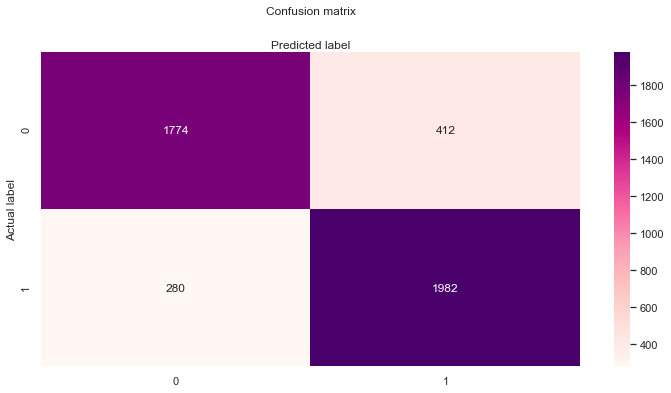

In [34]:
mpl.rcParams['figure.figsize']=(10,5)
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


# heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="RdPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()